# ML in the AWS Cloud with Amazon SageMaker

This noteboook shows how to bring a custom model script and port it for use with Amazon SageMaker for scaled remote training and hyperparameter tuning jobs. 

The Amazon SageMaker Python SDK provides open source APIs and containers that make it easy to train and deploy models with several different machine learning and deep learning frameworks. For general information about the Amazon SageMaker Python SDK, see https://sagemaker.readthedocs.io/.

In this workshop you will port a working Tensorflow CNN script to run on SageMaker for both training and hosting. In addition to Tensorflow, Amazon SageMaker also has managed support in both the SDK and containers for the following frameworks:
- sklearn
- PyTorch
- MxNet
- xgboost 
- SparkML

Custom frameworks are also supported if the user brings their own container image (BYOC). 


## The dataset
The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is one of the most popular machine learning datasets. It consists of 60,000 32x32 images belonging to 10 different classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)

In this tutorial, we will train a deep CNN to recognize these images.

### Verify the data
To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

Using TensorFlow backend.



170500096/170498071 [==============================] - 3s 0us/step


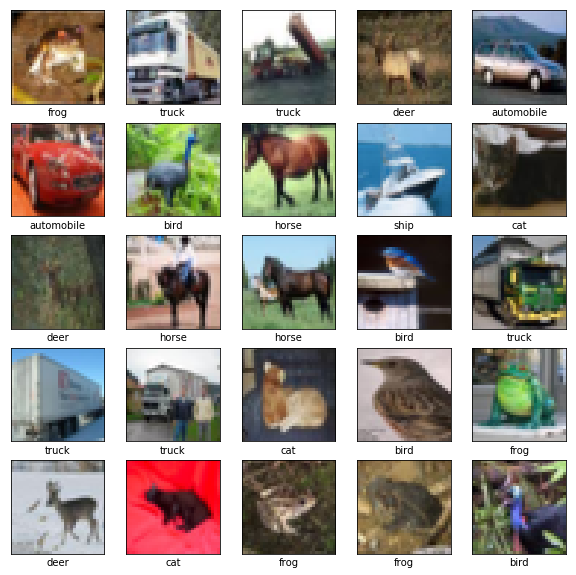

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

For the rest of this workshop, we'll work with the cifar10 data converted into [TFRecord files](https://www.tensorflow.org/tutorials/load_data/tfrecord) but the conversion itself is unimportant to the goal of the session. We'll just download some pre-prepared data from S3: 

note: tfrecords allow the use of SageMaker [Pipe Mode](https://aws.amazon.com/blogs/machine-learning/accelerate-model-training-using-faster-pipe-mode-on-amazon-sagemaker/) to help speed up model training for large datasets.

In [2]:
!aws s3 cp --recursive s3://floor28/data/cifar10 ./data

download: s3://floor28/data/cifar10/eval/eval.tfrecords to data/eval/eval.tfrecords
download: s3://floor28/data/cifar10/validation/validation.tfrecords to data/validation/validation.tfrecords
download: s3://floor28/data/cifar10/train/train.tfrecords to data/train/train.tfrecords


### The training script 

The script we'll be using to train the model (`cfiar10_keras.py`) can be found in the directory `training_scipt`.  The model used in this script is a simple deep CNN that was extracted from [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Let's have a look at the training script: 

In [3]:
!pygmentize training_script/cifar10_keras.py

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this
# software and associated documentation files (the "Software"), to deal in the Software
# without restriction, including without limitation the rights to use, copy, modify,
# merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
# permit persons to whom the Software is furnished to do so.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
# PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
# HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
# OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
# SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

from __future__ import absolute_import
fro

## Run the training script locally

The script uses arguments for configuration. it requires the following configurations:
1. Model_dir - location where it'll save checkpoints and logs
2. train, validation, eval - location of the relevant tf records

Run the script locally (on the notebook instance):

In [1]:
!mkdir -p logs
!python training_script/cifar10_keras.py --model_dir ./logs \
                                         --train data/train \
                                         --validation data/validation \
                                         --eval data/eval \
                                         --epochs 1
!rm -rf logs

Using TensorFlow backend.



2020-07-08 05:40:17.854492: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  AVX512F
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2020-07-08 05:40:17.941307: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2020-07-08 05:40:17.941558: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557e7a439120 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-08 05:40:17.941577: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-07-08 05:40:17.941781: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
getting dat

**Altough the script was running on a SageMaker notebook, you can run the same script on your computer using the same command.**

### Preparing your script for training in SageMaker
Running a training script with SageMaker does not require many changes from the training script we've already prepared. SageMaker will run your script inside the training environment along with optional parameters passed to it. 

You can access useful properties about the SageMaker training environment through various environment variables.
In this example, we are sending 3 data channels to the script: 
- Train 
- Validation
- Eval

**Create a copy of the script (training_script/cifar10_keras.py) and save it as training_script/cifar10_keras_sm.py.**

In cifar10_keras_sm.py, scroll down to the **if __name__ == '__main__':** section.  
Update the train,validation,eval arguments to get the data by default from the relevant environment variable: SM_CHANNEL_TRAIN, SM_CHANNEL_VALIDATION, SM_CHANNEL_EVAL
Add the default configuration to the arguments in **cifar10_keras_sm.py**.  
The lines should look as following:
```python
parser.add_argument(
        '--train',
        type=str,
        required=False,
        default=os.environ.get('SM_CHANNEL_TRAIN'),
        help='The directory where the CIFAR-10 input data is stored.')
parser.add_argument(
        '--validation',
        type=str,
        required=False,
        default=os.environ.get('SM_CHANNEL_VALIDATION'),
        help='The directory where the CIFAR-10 input data is stored.')
parser.add_argument(
        '--eval',
        type=str,
        required=False,
        default=os.environ.get('SM_CHANNEL_EVAL'),
        help='The directory where the CIFAR-10 input data is stored.')
```

For info see the SageMaker-python-sdk [documentation](https://sagemaker.readthedocs.io/en/stable/using_tf.html#preparing-a-script-mode-training-script)

SageMaker will not send the locations as arguments, it'll use environment variables instead.

SageMaker send different useful environment variables to your scripts, e.g.:
* `SM_MODEL_DIR`: A string that represents the local path where the training job can write the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting. This is different than the model_dir argument passed to your training script which is a S3 location. `SM_MODEL_DIR` is always set to /opt/ml/model.
* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.
* `SM_OUTPUT_DATA_DIR`: A string that represents the path to the directory to write output artifacts to. Output artifacts might include checkpoints, graphs, and other files to save, but do not include model artifacts. These artifacts are compressed and uploaded to S3 to an S3 bucket with the same prefix as the model artifacts.

In this Example, to reduce the network latency. we would like to save the model checkpoints locally, they will be uploaded to S3 at the end of the job.

Add the following argument to your script:
```python
parser.add_argument(
        '--model_output_dir',
        type=str,
        default=os.environ.get('SM_MODEL_DIR'))
```
Change the ModelCheckPoint line to use to new location:
```python
checkpoint = ModelCheckpoint(args.model_output_dir + '/checkpoint-{epoch}.h5')
```

Change the save_model call to use that folder.  
From:  
```python
return save_model(model, args.model_dir)
```
To:  
```python
return save_model(model, args.model_output_dir)
```

To test that we haven't made any breaking changes to our script, let's run it again with the same command as above, make sure it runs as expected.  
Add the new model_output_dir as an argument for the script. 

In [2]:
# Run the script locally
!mkdir -p logs
!python training_script/cifar10_keras_sm.py --model_dir ./logs \
                                         --model_output_dir ./logs \
                                         --train data/train \
                                         --validation data/validation \
                                         --eval data/eval \
                                         --epochs 1
!rm -rf logs

Using TensorFlow backend.



2020-07-08 05:42:27.557690: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  AVX512F
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2020-07-08 05:42:27.581314: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2020-07-08 05:42:27.581554: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55cb22e45fc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-08 05:42:27.581576: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-07-08 05:42:27.581784: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
getting dat

### Use SageMaker local mode for local testing

Local Mode in Amazon SageMaker is a convenient way to make sure your code is working locally as expected before moving on to full scale, hosted training in a separate, more powerful SageMaker-managed cluster. Training in local mode also allows us to easily monitor metrics like GPU consumption to ensure that our code is written properly to take advantage of the hardware we’re using.

The local mode in the Amazon SageMaker Python SDK can emulate CPU (single and multi-instance) and GPU (single instance) SageMaker training jobs by changing a single argument in the TensorFlow, Pytorch, MXNet, SKlearn, or xgboost estimators.  To do this, it uses Docker compose and NVIDIA Docker.  

In this example, the SageMaker SDK will pull the Amazon SageMaker TensorFlow container from Amazon ECR (Elastic Container Registry) and deploy it onto our local notebook instance.

To begin, we'll import the sagemaker python library and set up a SageMaker Session to perform various operations. We'll also set a `role` to the same execution role used by this notebook instance which will be used for other SageMaker operations throughout this workshop. 

In [3]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

Next, we'll set up a TensorFlow Estimator for Local Mode training. Key parameters for the Estimator include:

- `train_instance_type`: the kind of hardware on which training will run. In the case of Local Mode, we simply set this parameter to local to invoke Local Mode training on the CPU, or to local_gpu if the instance has a GPU.
- `entry_point`: Path to the local Python source file which should be executed as the entry point to training
- `source_dir`: Path to a directory with any other training source code dependencies aside from the entry point file. If there are other packages you want to use with your script, you can place `requirements.txt` in this directory which SageMaker will use to `pip install` other dependencies at runtime. 
- `hyperparameters`: Hyperparameters that will be used for training.

Instead of performing a full cycle of training with many epochs (passes over the full dataset), we'll train only for a small number of epochs just to confirm the code is working properly and avoid wasting full-scale training time unnecessarily.

For info see the [documentation](https://sagemaker.readthedocs.io/en/stable/using_tf.html#training-with-tensorflow-estimator)

In [4]:
from sagemaker.tensorflow import TensorFlow

local_estimator = TensorFlow(base_job_name='cifar10',
                       entry_point='cifar10_keras_sm.py',
                       source_dir='training_script',
                       role=role,
                       framework_version='1.12.0',
                       py_version='py3',
                       hyperparameters={'epochs' : 1},
                       train_instance_count=1, 
                       train_instance_type='local')

The fit method call below starts the Local Mode training job. Metrics for training will be logged below the code, inside the notebook cell. 

In [5]:
local_estimator.fit({'train' :  'file://data/train',
               'validation' :  'file://data/validation',
               'eval' :  'file://data/eval'})

Creating tmpekvy71ki_algo-1-9a7la_1 ... 
Attaching to tmpekvy71ki_algo-1-9a7la_12mdone
algo-1-9a7la_1  | 2020-07-08 05:45:21,128 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-9a7la_1  | 2020-07-08 05:45:21,134 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-9a7la_1  | 2020-07-08 05:45:21,298 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-9a7la_1  | 2020-07-08 05:45:21,312 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-9a7la_1  | 2020-07-08 05:45:21,322 sagemaker-containers INFO     Invoking user script
algo-1-9a7la_1  | 
algo-1-9a7la_1  | Training Env:
algo-1-9a7la_1  | 
algo-1-9a7la_1  | {
algo-1-9a7la_1  |     "additional_framework_parameters": {},
algo-1-9a7la_1  |     "channel_input_dirs": {
algo-1-9a7la_1  |         "train": "/opt/ml/input/data/train",
algo-1-9a7la_1  |         "validation": "/opt/ml/input/data/validation",

The first time the estimator runs, it needs to download the container image from its Amazon ECR repository, but then training can begin immediately.  There’s no need to wait for a separate training cluster to be provisioned. Any subsequent runs from changes to your script will start to run instantaneously which may be necessary when iterating and testing.

## SageMaker remote training job
Now that we've confirmed our code is working locally, we can move on to use SageMaker's remote training functionality. Remote training jobs are preferred for doing actual model training, especially large-scale, distributed training. Unlike Local Mode training, the actual training itself occurs not on the notebook instance, but on a separate cluster of machines managed by SageMaker. Before starting hosted training, the data must be in S3, or an EFS or FSx for Lustre file system. We'll upload to S3 now, and confirm the upload was successful.

In [6]:
dataset_location = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-cifar10')
display(dataset_location)

's3://sagemaker-us-east-1-888074057978/data/DEMO-cifar10'

In [7]:
inputs = {'train': dataset_location+'/train/',
          'validation': dataset_location+'/validation/', 
          'eval': dataset_location+'/eval/'}

print(inputs)

{'train': 's3://sagemaker-us-east-1-888074057978/data/DEMO-cifar10/train/', 'validation': 's3://sagemaker-us-east-1-888074057978/data/DEMO-cifar10/validation/', 'eval': 's3://sagemaker-us-east-1-888074057978/data/DEMO-cifar10/eval/'}


**Managed Spot Training**: To save on cost, we run the training using managed Spot instances. With Managed Spot, customers can benefit from up-to 90% savings in cost. [More information can be found here](https://aws.amazon.com/blogs/aws/managed-spot-training-save-up-to-90-on-your-amazon-sagemaker-training-jobs/)

For BYO Containers, customers are responsible for checkpointing models for the spot instances to resume training from, if a spot instance is lost during training.

**Custom Metrics in CloudWatch** Our training script outputs metrics at every epoch for loss and accuracy on the training and validation sets. We'd like to monitor these in Amazon CloudWatch, so we can pass in a dictionary called `metric_definitions` into our estimator which tells SageMaker how to find the relevant metrics from the training log using regular expressions.

We'll create a new estimator, but this time we'll use the **ml.p3.2xlarge** as the instance type and configure **epochs:20**. 

In [8]:
metric_definitions = [{'Name': 'loss',
                       'Regex': ' loss: ([0-9\\.]+)'},
                     {'Name': 'val_loss',
                       'Regex': ' val_loss: ([0-9\\.]+)'},
                     {'Name': 'acc',
                       'Regex': ' acc: ([0-9\\.]+)'},
                     {'Name': 'val_acc',
                       'Regex': ' val_acc: ([0-9\\.]+)'}]

In [9]:
estimator = TensorFlow(base_job_name='cifar10',
                       entry_point='cifar10_keras_sm.py',
                       source_dir='training_script',
                       role=role,
                       framework_version='1.12.0',
                       py_version='py3',
                       hyperparameters={'epochs' : 20},
                       train_instance_count=1, 
                       train_instance_type='ml.p3.2xlarge',
                       metric_definitions=metric_definitions,
                       train_use_spot_instances=True,
                       train_max_wait=3600,
                       train_max_run=3600)

After starting the remote training job with the fit method call below, you should observe the training converge over the longer number of epochs to a validation loss that is considerably lower than that which was achieved in the shorter Local Mode training job. Can we do better? We'll look into a way to do so in the Automatic Model Tuning section below.

In [ ]:
estimator.fit(inputs)

2020-07-08 05:48:10 Starting - Starting the training job...
2020-07-08 05:48:13 Starting - Launching requested ML instances......
2020-07-08 05:49:29 Starting - Preparing the instances for training.........
2020-07-08 05:50:49 Downloading - Downloading input data...
2020-07-08 05:51:25 Training - Downloading the training image..2020-07-08 05:51:49,012 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-07-08 05:51:49,346 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
        "validation": "/opt/ml/input/data/validation",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://sagemaker-us-east-1-888074057978/cifar10-2020-07-08

**Good job!** 
You were able to run 20 epochs on a bigger instance in SageMaker.  

As with the Local Mode training, remote training produces a model saved in S3 that we can retrieve. This is an example of the modularity of SageMaker: having trained the model in SageMaker, you can now take the model out of SageMaker and run it anywhere else. Alternatively, you can deploy the model into a production-ready environment using SageMaker's hosted endpoints functionality, as shown in the SageMaker hosted endpoint section below.

Retrieving the model from S3 is very easy: the hosted training estimator you created above stores a reference to the model's location in S3. You simply copy the model from S3 using the estimator's model_data property and unzip it to inspect the contents.

In [22]:
!aws s3 cp {estimator.model_data} ./model/model.tar.gz

download: s3://sagemaker-us-east-1-888074057978/cifar10-2020-07-07-23-05-21-448/output/model.tar.gz to model/model.tar.gz


The unzipped archive should include the assets required by TensorFlow Serving to load the model and serve it, including a .pb file:

In [23]:
!tar -xvzf ./model/model.tar.gz -C ./model

checkpoint-16.h5
checkpoint-11.h5
checkpoint-15.h5
checkpoint-13.h5
checkpoint-1.h5
checkpoint-18.h5
checkpoint-17.h5
checkpoint-20.h5
checkpoint-6.h5
checkpoint-19.h5
checkpoint-10.h5
checkpoint-12.h5
checkpoint-9.h5
checkpoint-7.h5
checkpoint-8.h5
checkpoint-5.h5
checkpoint-2.h5
1/
1/saved_model.pb
1/variables/
1/variables/variables.data-00000-of-00001
1/variables/variables.index
checkpoint-14.h5
checkpoint-4.h5
checkpoint-3.h5


### Automatic Model Tuning
So far we have simply run one Local Mode training job and one Hosted Training job without any real attempt to tune hyperparameters to produce a better model, other than increasing the number of epochs. Selecting the right hyperparameter values to train your model can be difficult, and typically is very time consuming if done manually. The right combination of hyperparameters is dependent on your data and algorithm; some algorithms have many different hyperparameters that can be tweaked; some are very sensitive to the hyperparameter values selected; and most have a non-linear relationship between model fit and hyperparameter values. SageMaker Automatic Model Tuning helps automate the hyperparameter tuning process: it runs multiple training jobs with different hyperparameter combinations to find the set with the best model performance.

We begin by specifying the hyperparameters we wish to tune, and the range of values over which to tune each one. We also must specify an objective metric to be optimized: in this use case, we'd like to minimize the validation loss.

In [24]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
  'learning-rate': ContinuousParameter(0.001, 0.2, scaling_type="Logarithmic"),
  'batch-size': CategoricalParameter([64, 128, 256, 512]),
   'optimizer': CategoricalParameter(['sgd', 'adam', 'rmsprop']),
}

objective_metric_name = 'val_acc'
objective_type = 'Maximize'


Next we specify a HyperparameterTuner object that takes the above definitions as parameters. Each tuning job must be given a budget: a maximum number of training jobs. A tuning job will complete after that many training jobs have been executed.

We also can specify how much parallelism to employ, in this case two jobs, meaning that the tuning job will complete after several series of two jobs in parallel have completed 15 jobs in total. For the default Bayesian Optimization tuning strategy used here, the tuning search is informed by the results of previous groups of training jobs, so we don't run all of the jobs in parallel, but rather divide the jobs into groups of parallel jobs. There is a trade-off: using more parallel jobs will finish tuning sooner, but likely will sacrifice tuning search accuracy.

Now we can launch a hyperparameter tuning job by calling the fit method of the HyperparameterTuner object. The tuning job may take around 10 minutes to finish. While you're waiting, the status of the tuning job, including metadata and results for invidual training jobs within the tuning job, can be checked in the SageMaker console in the Hyperparameter tuning jobs panel.

In [25]:
from time import gmtime, strftime 

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=10,
                            max_parallel_jobs=2,
                            objective_type=objective_type,
                            early_stopping_type='Auto',)

tuning_job_name = "cifar10-remote-hpo-{}".format(strftime("%d-%H-%M-%S", gmtime()))
tuner.fit(inputs, job_name=tuning_job_name)

INFO:root:_TuningJob.start_new!!!
INFO:sagemaker:Creating hyperparameter tuning job with name: cifar10-remote-hpo-07-23-15-06


We've configured early stopping in this automatic tuning job where SageMaker will stop the training jobs that a hyperparameter tuning job launches when they are not improving significantly as measured by the objective metric. Stopping training jobs early can help reduce compute time and helps you avoid overfitting your model.

Have a look in the console to see how the hyperparameter tuning job is progressing. You should see at least a few training jobs stopping early. 


After the tuning job is finished, we can use the HyperparameterTuningJobAnalytics object from the SageMaker Python SDK to list the top 5 tuning jobs with the best performance. Although the results vary from tuning job to tuning job, the best validation loss from the tuning job (under the FinalObjectiveValue column) likely will be substantially lower than the validation loss from the hosted training job above, where we did not perform any tuning other than manually increasing the number of epochs once.

In [56]:
#wait to run until HPO job completes
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuner_metrics.dataframe().sort_values(['FinalObjectiveValue'], ascending=False).head(5)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,batch-size,learning-rate,optimizer
9,0.7981,246.0,2020-07-07 22:02:11+00:00,cifar10-remote-hpo-07-21-55-00-001-01122e39,Completed,2020-07-07 21:58:05+00:00,"""128""",0.002709,"""adam"""
7,0.7856,371.0,2020-07-07 22:09:00+00:00,cifar10-remote-hpo-07-21-55-00-003-2405b369,Completed,2020-07-07 22:02:49+00:00,"""64""",0.009507,"""adam"""
5,0.7792,241.0,2020-07-07 22:17:13+00:00,cifar10-remote-hpo-07-21-55-00-005-6ac2ddc5,Completed,2020-07-07 22:13:12+00:00,"""256""",0.002637,"""adam"""
6,0.7506,357.0,2020-07-07 22:12:38+00:00,cifar10-remote-hpo-07-21-55-00-004-a6778d9b,Completed,2020-07-07 22:06:41+00:00,"""64""",0.010025,"""adam"""
4,0.6897,288.0,2020-07-07 22:19:49+00:00,cifar10-remote-hpo-07-21-55-00-006-2d372e1d,Completed,2020-07-07 22:15:01+00:00,"""64""",0.002937,"""sgd"""


# Model Deployment 

While it’s designed to alleviate the undifferentiated heavy lifting from the full life cycle of ML models, Amazon SageMaker’s capabilities can also be used independently of one another; that is, models trained in Amazon SageMaker can be optimized and deployed outside of Amazon SageMaker (or even out of the cloud on mobile or IoT devices at the edge). Conversely, Amazon SageMaker can deploy and host pre-trained models from model zoos, or other members of your team.

Amazon SageMaker will deploy your model to a TensorFlow Serving-based server. The server provides a super-set of the [TensorFlow Serving REST API](https://www.tensorflow.org/serving/api_rest).

## Local Mode endpoint

While Amazon SageMaker’s Local Mode training is very useful to make sure your training code is working before moving on to full scale training, it also would be useful to have a convenient way to test your model locally before incurring the time and expense of deploying it to production. One possibility is to fetch the TensorFlow SavedModel artifact or a model checkpoint saved in Amazon S3, and load it in your notebook for testing. However, an even easier way to do this is to use the SageMaker Python SDK to do this work for you by setting up a Local Mode endpoint.

More specifically, the Estimator object from the Local Mode training job can be used to deploy a model locally. With one exception, this code is the same as the code you would use to deploy to production. In particular, all you need to do is invoke the local Estimator's deploy method, and similarly to Local Mode training, specify the instance type as either local_gpu or local depending on whether your notebook is on a GPU instance or CPU instance.

While we wait for the Automatic tuning job to finish, let's deploy the first model we trained using SageMaker's local training mode to test out the process. The following single line of code deploys the model locally in the SageMaker TensorFlow Serving container:

In [26]:
local_predictor = local_estimator.deploy(initial_instance_count=1, 
                                         instance_type='local')

INFO:sagemaker:Creating model with name: cifar10-2020-07-07-22-56-54-392
INFO:sagemaker:Creating endpoint with name cifar10-2020-07-07-22-56-54-392
INFO:sagemaker.local.image:serving
INFO:sagemaker.local.image:creating hosting dir in /tmp/tmpyq9vlya_
INFO:sagemaker.local.image:docker command: docker pull 520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tensorflow-serving:1.12-cpu
INFO:sagemaker.local.image:image pulled: 520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tensorflow-serving:1.12-cpu
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-5do84:
    command: serve
    environment:
    - SAGEMAKER_TFS_NGINX_LOGLEVEL=info
    image: 520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tensorflow-serving:1.12-cpu
    networks:
      sagemaker-local:
        aliases:
        - alg

Attaching to tmpyq9vlya__algo-1-5do84_1
algo-1-5do84_1  | INFO:__main__:starting services
algo-1-5do84_1  | INFO:__main__:using default model name: model
algo-1-5do84_1  | INFO:__main__:tensorflow serving model config: 
algo-1-5do84_1  | model_config_list: {
algo-1-5do84_1  |   config: {
algo-1-5do84_1  |     name: "model",
algo-1-5do84_1  |     base_path: "/opt/ml/model",
algo-1-5do84_1  |     model_platform: "tensorflow"
algo-1-5do84_1  |   }
algo-1-5do84_1  | }
algo-1-5do84_1  | 
algo-1-5do84_1  | 
algo-1-5do84_1  | INFO:__main__:nginx config: 
algo-1-5do84_1  | load_module modules/ngx_http_js_module.so;
algo-1-5do84_1  | 
algo-1-5do84_1  | worker_processes auto;
algo-1-5do84_1  | daemon off;
algo-1-5do84_1  | pid /tmp/nginx.pid;
algo-1-5do84_1  | error_log  /dev/stderr info;
algo-1-5do84_1  | 
algo-1-5do84_1  | worker_rlimit_nofile 4096;
algo-1-5do84_1  | 
algo-1-5do84_1  | events {
algo-1-5do84_1  |   worker_connections 2048;
algo-1-5do84_1  | }
algo-1-5do84_1  | 
algo-1-5do84_1  

INFO:sagemaker.local.entities:Checking if serving container is up, attempt: 15


!algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:15:35 +0000] "GET /ping HTTP/1.1" 200 3 "-" "-"


To get predictions from the Local Mode endpoint, simply invoke the Predictor's predict method. To verify the that the endpoint functions properly, we generate random data in the correct shape and get a prediction.

In [27]:
# Creating fake prediction data
import numpy as np
data = np.random.randn(1, 32, 32, 3)
print("Predicted class is {}\n".format(np.argmax(local_predictor.predict(data)['predictions'])))

Predicted class is 3

algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:15:58 +0000] "POST /invocations HTTP/1.1" 200 138 "-" "-"


In [28]:
from sklearn.metrics import confusion_matrix
datagen = ImageDataGenerator()

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def predict(data):
    predictions = local_predictor.predict(data)['predictions']
    return predictions

In [29]:
batch_size = 128
predicted = []
actual = []
batches = 0
for data in datagen.flow(x_test,y_test,batch_size=batch_size):
    for i,prediction in enumerate(predict(data[0])):
        predicted.append(np.argmax(prediction))
        actual.append(data[1][i][0])
    batches += 1
    if batches >= len(x_test) / batch_size:
        break

algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:07 +0000] "POST /invocations HTTP/1.1" 200 14314 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:07 +0000] "POST /invocations HTTP/1.1" 200 14390 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:08 +0000] "POST /invocations HTTP/1.1" 200 14442 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:08 +0000] "POST /invocations HTTP/1.1" 200 14501 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:09 +0000] "POST /invocations HTTP/1.1" 200 14453 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:09 +0000] "POST /invocations HTTP/1.1" 200 14373 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:10 +0000] "POST /invocations HTTP/1.1" 200 14499 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:11 +0000] "POST /invocations HTTP/1.1" 200 14421 "-" "-"
algo-1-5do84_1  | 172.18.0.1 - - [07/Jul/2020:23:16:11 +0000] "POST /invocations HTTP/1.1" 200 14441 "-" "-"
algo-1-5do84_1  | 1

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_pred=predicted,y_true=actual)
display('Average accuracy: {}%'.format(round(accuracy*100,2)))

'Average accuracy: 35.63%'

Using this heatmap we can calculate the accuracy of each one of the labels

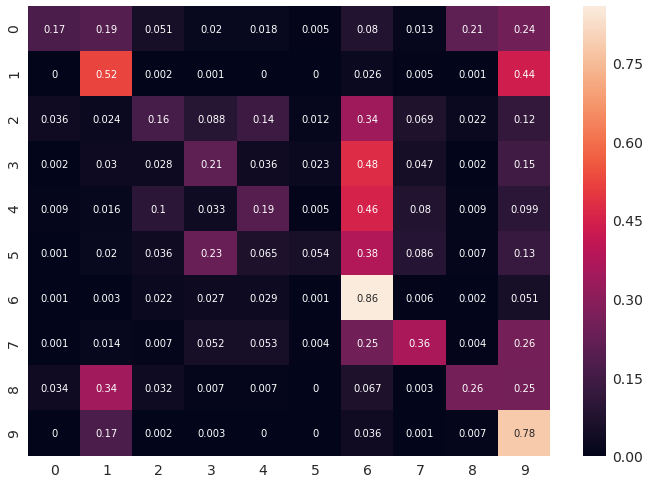

In [31]:
import seaborn as sn
import pandas as pd

cm = confusion_matrix(y_pred=predicted,y_true=actual)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, annot=True,annot_kws={"size": 10})# font size

To avoid having the SageMaker TensorFlow Serving container indefinitely running locally, simply gracefully shut it down by calling the delete_endpoint method of the Predictor object.

In [32]:
local_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: cifar10-2020-07-07-22-56-54-392
INFO:sagemaker:Deleting endpoint with name: cifar10-2020-07-07-22-56-54-392


Gracefully stopping... (press Ctrl+C again to force)


### SageMaker hosted endpoint
Assuming the best model from the tuning job is better than the model produced by the individual Hosted Training job above, we could now easily deploy that model to production. A convenient option is to use a SageMaker hosted endpoint, which serves real time predictions from the trained model (Batch Transform jobs also are available for asynchronous, offline predictions on large datasets). The endpoint will retrieve the TensorFlow SavedModel created during training and deploy it within a SageMaker TensorFlow Serving container. This all can be accomplished with one line of code.

More specifically, by calling the deploy method of the HyperparameterTuner object we instantiated above, we can directly deploy the best model from the tuning job to a SageMaker hosted endpoint. It will take several minutes longer to deploy the model to the hosted endpoint compared to the Local Mode endpoint, which is more useful for fast prototyping of inference code.

Once the hyperparameter job finishes, we can create a hosted endpoint from the best model that resulted from the HPO job. We simply need to create a new predictor from the `tuner` object and deploy it an instance type:



In [ ]:
tuning_predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')